In [237]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [239]:
# get data - load it once to get your .csv

# decide the entity's prices to extract and the timelapse (from X-ago to today. Daily timestamps)
# returns a dataframe with Date as an index and Close (prices) in a column

import yfinance as yf
import time
from datetime import date
from dateutil.relativedelta import relativedelta

end = time.strftime("%Y-%m-%d")   # today  
start = (date.today()+relativedelta(years=-10)).strftime("%Y-%m-%d")    # 'yyyy-mm-dd' - from 10 years ago
entity = '^GSPC'  

get_data = yf.download(entity, start, end)
get_data.to_csv("stocks.csv")

[*********************100%***********************]  1 of 1 completed


In [366]:
# select X years of data, into a dataframe

data = pd.read_csv('C:/Users/camib/Stock_project/stocks.csv', parse_dates=True, index_col='Date')
start_date='2013-04-26'
stop_date='2021-04-26'
data = data[start_date:stop_date]
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-26,23.309999,23.559999,23.139999,23.400000,18.482595,101377300
2013-04-29,23.440001,23.830000,23.400000,23.760000,18.766939,102141600
2013-04-30,23.719999,24.000000,23.639999,23.950001,18.917017,41468900
2013-05-01,23.820000,24.170000,23.809999,23.990000,18.948610,38373800
2013-05-02,23.730000,24.150000,23.670000,24.110001,19.043394,33486300


In [367]:
# prepare for Prophet :
# Date was set as an index previously, which facilitated to select the timelapse
# Prophet can run when Date is set as 1st column, Close as 2nd column (it's how it works)

data = data.reset_index()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-04-26,23.309999,23.559999,23.139999,23.400000,18.482595,101377300
1,2013-04-29,23.440001,23.830000,23.400000,23.760000,18.766939,102141600
2,2013-04-30,23.719999,24.000000,23.639999,23.950001,18.917017,41468900
3,2013-05-01,23.820000,24.170000,23.809999,23.990000,18.948610,38373800
4,2013-05-02,23.730000,24.150000,23.670000,24.110001,19.043394,33486300


In [368]:
# actually should select Adjusted Close rather than Close prices... but I keep getting an error when I do (will do later)
# df = yf.download('MSFT', start='2019-01-01', end='2020-05-30')['Adj Close']

In [369]:
# Select only the important features : Date and Close prices

data = data[["Date","Close"]]
data.tail()

,Date,Close
2009,2021-04-20,62.700001
2010,2021-04-21,63.700001
2011,2021-04-22,62.570000
2012,2021-04-23,59.240002
2013,2021-04-26,58.759998


In [370]:
# For prophet to work, need to change the names of these columns to 'ds' and 'y'
# create new DF 

df_to_use = data.rename(columns={'Date':'ds','Close':'y'})
df_to_use.tail()

,ds,y
2009,2021-04-20,62.700001
2010,2021-04-21,63.700001
2011,2021-04-22,62.570000
2012,2021-04-23,59.240002
2013,2021-04-26,58.759998


<AxesSubplot:xlabel='ds'>

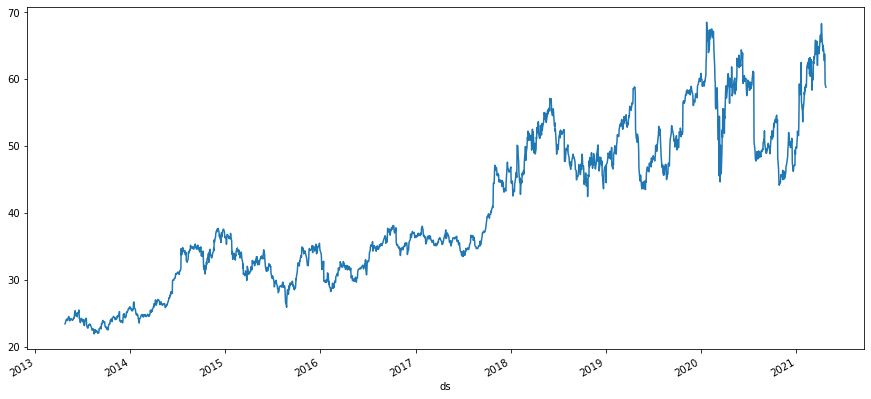

In [371]:
# set plotting windows
# plot the Close prices over time from 2015-04-26 to 2021-04-26

plt.rcParams['figure.figsize']=(15,7)
df_to_use.set_index('ds').y.plot()

In [372]:
train_ratio = 0.80*len(df_to_use)
#test_ratio = 0.15*len(df_to_use)

#int(train_ratio)
#int(test_ratio)

In [373]:
train = df_to_use[:int(train_ratio)]
test = df_to_use[int(train_ratio):]

#train.tail()
len(test)

403

In [374]:
# fit the model

model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [375]:
# create new dataframe in which we're gonna store the values of the next 'periods=' days

future = model.make_future_dataframe(periods=len(test), freq = 'd')


# eliminate weekends from created 'future' dataframe (prices are only on business days)
# Prophet predicts on weekends, so better remove weekends beforehands from the dataframe before using predict()
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]


In [376]:
# forecast

forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1893,2020-10-19,46.925773,36.575557,55.221917,37.331411,55.975715,-0.742393,-0.742393,-0.742393,0.046554,0.046554,0.046554,-0.788947,-0.788947,-0.788947,0.0,0.0,0.0,46.183380
1894,2020-10-20,46.921683,36.376357,54.890541,37.253722,56.012722,-0.605842,-0.605842,-0.605842,0.136976,0.136976,0.136976,-0.742819,-0.742819,-0.742819,0.0,0.0,0.0,46.315840
1895,2020-10-21,46.917592,35.742539,55.615783,37.218533,56.046137,-0.570509,-0.570509,-0.570509,0.120992,0.120992,0.120992,-0.691502,-0.691502,-0.691502,0.0,0.0,0.0,46.347083
1896,2020-10-22,46.913502,36.568610,55.988080,37.191766,56.073634,-0.568543,-0.568543,-0.568543,0.066742,0.066742,0.066742,-0.635285,-0.635285,-0.635285,0.0,0.0,0.0,46.344959
1897,2020-10-23,46.909411,36.398293,55.609454,37.164998,56.092186,-0.543606,-0.543606,-0.543606,0.030948,0.030948,0.030948,-0.574555,-0.574555,-0.574555,0.0,0.0,0.0,46.365805


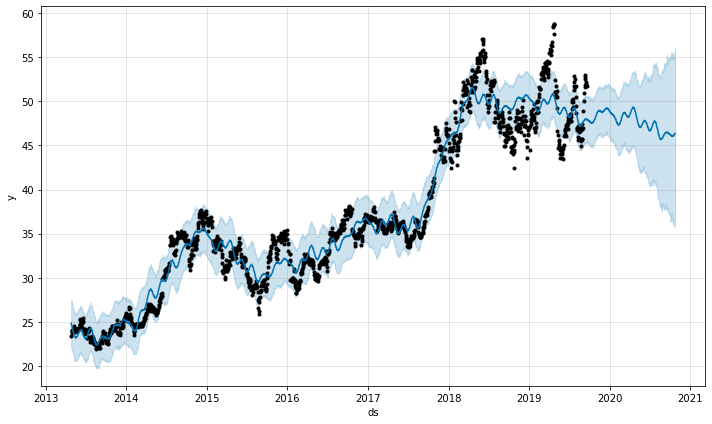

'\nblack dots : observed values of time series\nblue line : the forecast values\nblue shaded region : uncertainty intervals of our predictions (by default set to 0.8)\n'

In [377]:
model.plot(forecast, uncertainty=True)
plt.show()

"""
black dots : observed values of time series
blue line : the forecast values
blue shaded region : uncertainty intervals of our predictions (by default set to 0.8)
"""

In [378]:
forecast.tail()
# solo values of interest : ds, yhat, yhat_lower, yhat_upper

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1893,2020-10-19,46.925773,36.575557,55.221917,37.331411,55.975715,-0.742393,-0.742393,-0.742393,0.046554,0.046554,0.046554,-0.788947,-0.788947,-0.788947,0.0,0.0,0.0,46.183380
1894,2020-10-20,46.921683,36.376357,54.890541,37.253722,56.012722,-0.605842,-0.605842,-0.605842,0.136976,0.136976,0.136976,-0.742819,-0.742819,-0.742819,0.0,0.0,0.0,46.315840
1895,2020-10-21,46.917592,35.742539,55.615783,37.218533,56.046137,-0.570509,-0.570509,-0.570509,0.120992,0.120992,0.120992,-0.691502,-0.691502,-0.691502,0.0,0.0,0.0,46.347083
1896,2020-10-22,46.913502,36.568610,55.988080,37.191766,56.073634,-0.568543,-0.568543,-0.568543,0.066742,0.066742,0.066742,-0.635285,-0.635285,-0.635285,0.0,0.0,0.0,46.344959
1897,2020-10-23,46.909411,36.398293,55.609454,37.164998,56.092186,-0.543606,-0.543606,-0.543606,0.030948,0.030948,0.030948,-0.574555,-0.574555,-0.574555,0.0,0.0,0.0,46.365805


In [379]:
# performance - RMSE - test/true

from sklearn.metrics import mean_squared_error
metric_prophet = forecast.set_index('ds')[['yhat']].join(test.set_index('ds').y).reset_index()
metric_prophet.dropna(inplace=True)
rms_prophet = mean_squared_error(metric_prophet.y, metric_prophet.yhat)
print("RMSE = {}".format(rms_prophet))

RMSE = 98.26034346229572


In [380]:
# performance - R^2

from sklearn.metrics import r2_score
r2_score(metric_prophet.y, metric_prophet.yhat)

# hmmmm???? 

-2.520817503799421

<AxesSubplot:xlabel='ds'>

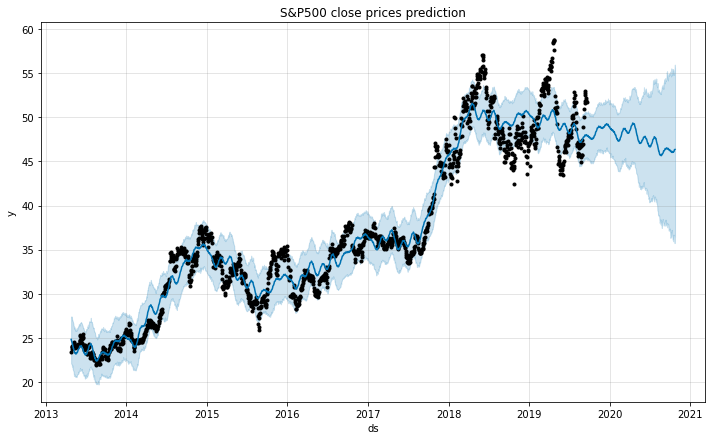

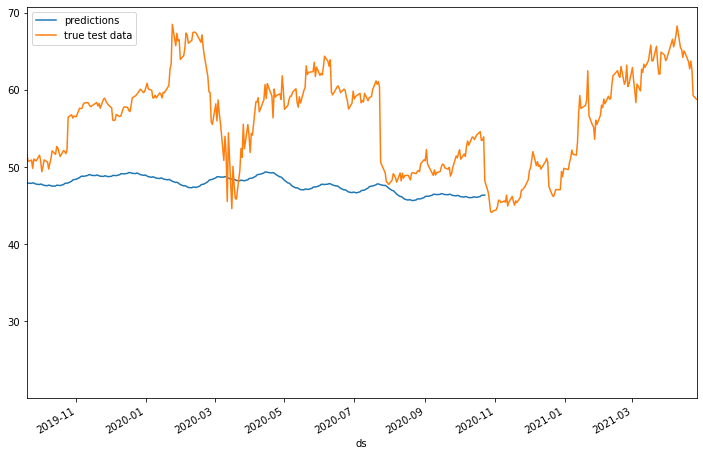

In [382]:
testset_First_date = df_to_use.ds[int(train_ratio)].strftime("%Y-%m-%d")
testset_Last_date = df_to_use.ds[len(df_to_use)-1].strftime("%Y-%m-%d")

model.plot(forecast)
plt.title('S&P500 close prices prediction')

ax = forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='true test data',ax=ax,\
          xlim=(testset_First_date, testset_Last_date))
